In [4]:
%pip install einops

Defaulting to user installation because normal site-packages is not writeable


In [44]:
#!L
%pip install wandb

Defaulting to user installation because normal site-packages is not writeable


In [3]:
#!L
from hidt_model import HiDTModel

In [2]:
#!L
print(1)

1


In [5]:
#!L
import torch
model = HiDTModel(device=torch.device('cuda'))

In [6]:
#!L
import os
from pathlib import Path
from random import randint
from typing import List

import matplotlib.pyplot as plt
import cv2
from albumentations import (
    Compose,
    HorizontalFlip,
    Normalize,
    Resize,
    SmallestMaxSize,
    CenterCrop
)

from albumentations.pytorch import ToTensorV2
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

from Dataset import LandscapesDataset

In [7]:
#!L
path = Path('/home/jupyter/work/resources/DaytimeTranslation/data/images')
dataset = LandscapesDataset(path)
train_dataloader = DataLoader(
            dataset=dataset,
            batch_size=4,
            num_workers=4,
        )

In [8]:
#!L
torch.cuda.is_available()

True

In [22]:
#!L
import wandb
wandb.init(project="HiDT");
wandb.watch(model)

total loss,0.46133
adversarial loss,0.55136
image reconstruction loss,0.89352
content reconstruction loss,0.01146
style reconstruction loss,0.03258
random style reconstruction loss,0.99761
style distribution loss,8.19995
_runtime,1050
_timestamp,1617781838
_step,37
adversarial noise loss,0.2307


total loss,▇▁█▁▇▁▇▁▇▁▇▁▇▁▇▁▇▁█▁▆▁▇▁▆▁▆▁▇▁▆▁▆▁▇▁
adversarial loss,▂█▅▃▃▃▃▆▆▄▃▃▃▂▂▁▂▁
image reconstruction loss,▆▄▄▄▄█▇▃▄▄▂▃▁▃▆▅▂▃
content reconstruction loss,█▅▄▆▂▁▁▄▆▆▃▅▃▄▁▁▆▃
style reconstruction loss,▁▄▂▄▂▃▂▁▃█▂▂▂▂▁▂▂▂
random style reconstruction loss,▂▆▅▂▂▃▄▅▃█▁▅▄▃▄▂▃▇
style distribution loss,██▇▇▇▇▆▅▅▅▃▃▃▃▂▂▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
adversarial noise loss,▆▁▃▆▅▅▅▃▄▅▅▆▆▇▇▇▇█


In [23]:
#!L
from torchvision.utils import make_grid
import tqdm
import torch.nn.utils as utils


model.train()
model.to(torch.device('cuda'))
optimizers, schedulers = model.configure_optimizers()
for epoch in range(10):
    for batch_idx, batch in enumerate(tqdm.tqdm(train_dataloader)):
        for optimizer_idx, optimizer in enumerate(optimizers):
            info = model.training_step(
                batch=batch,
                batch_idx=batch_idx,
                optimizer_idx=optimizer_idx,
            )
            if (batch_idx + 1) % 100 == 0:
                logger_dict = {}
                for metric_name, value in info.items():
                    logger_dict[metric_name] = value.item()
                wandb.log(logger_dict)

            loss = info['total loss']
            loss.backward()
            utils.clip_grad_norm_(
                parameters=model.parameters(),
                max_norm=10,
            )
            optimizer.step()
            optimizer.zero_grad()

    torch.save(model.state_dict(), f'checkpoints/model{epoch}.pt')
    with torch.no_grad():
        batch = next(iter(train_dataloader))
        sample = model.sample(batch)

    images = (make_grid(sample, nrow=4).detach().cpu().permute(1,2,0) * Tensor([0.406, 0.456, 0.485]) + 
              Tensor([0.225, 0.224, 0.229])).numpy()
    wandb.log({"generated images": [wandb.Image(images)]})

 42%|████▏     | 396/946 [03:32<04:55,  1.86it/s]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


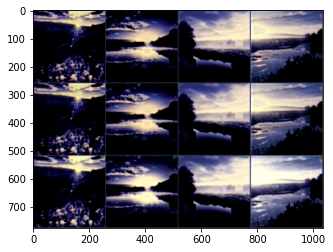

In [21]:
#!L
import matplotlib.pyplot as plt
with torch.no_grad():
    batch = next(iter(train_dataloader))
    sample = model.sample(batch)
images = (make_grid(sample, nrow=4).detach().cpu().permute(1,2,0) * Tensor([0.406, 0.456, 0.485]) + 
          Tensor([0.225, 0.224, 0.229])).numpy()
plt.imshow(images)

In [24]:
#!L


Dataset.ipynb  checkpoints	hidt_model.ipynb  model_base.py
Dataset.py     core		hidt_model.py	  model_baseline.ipynb
__pycache__    hidt_components	model_base.ipynb  wandb
